In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 21:02:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   28C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_labels(base_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(base_path):
        filepath = os.path.join(base_path, filename)
        if filepath.endswith(".png") and not "_mask" in filepath:
            images.append(filepath)
            labels.append(class_label)
    return images, labels

# Load benign and malignant images and masks
benign_images, benign_labels = load_images_and_labels("./Dataset_BUSI_with_GT/benign/", 0)
malignant_images, malignant_labels  = load_images_and_labels("./Dataset_BUSI_with_GT/malignant/", 1)

# Combine benign and malignant images and masks
images = benign_images + malignant_images
labels = benign_labels + malignant_labels

# Split the dataset into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, labels, img_width, img_height, is_augment=True):
        self.images = images
        self.labels = labels
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        mask = Image.open(self.images[index][:-4] + "_mask.png").resize((self.img_width, self.img_height))
        mask = np.array(mask, dtype=np.float32)
        label = torch.from_numpy(np.array(self.labels))[index].type(torch.LongTensor)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                mask = cv2.warpAffine(mask, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                mask = cv2.flip(mask, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])
        
        y_transform = transforms.Compose([
            ToLabel(),
        ])

        img_new = tfms(img_new)
        mask = y_transform(mask)

        return img_new, label, mask

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, labels_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, labels_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))




Training samples #:  517
Test samples #:  130


In [6]:
class ResNet50Multi(nn.Module):
    def __init__(self, n_classes):
        super(ResNet50Multi, self).__init__()

        # Load a pretrained ResNet50 model
        resnet50 = models.resnet50(pretrained=True)
        self.pool = resnet50.avgpool
        num_features = resnet50.fc.in_features  # Number of input features to the final fully connected layer
        self.classifier = torch.nn.Linear(num_features, 2)  # Replace the final fully connected layer

        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = nn.Sequential(*(list(resnet50.children())[0:3]))
        self.enc_features2 = nn.Sequential(*(list(resnet50.children())[3:5]))
        self.enc_features3 = nn.Sequential(*(list(resnet50.children())[5:6]))
        self.enc_features4 = nn.Sequential(*(list(resnet50.children())[6:7]))
        self.enc_features5 = nn.Sequential(*(list(resnet50.children())[7:8]))
        # Now, self.enc_features contains the encoder part of ResNet50

        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(2048, 1024)
        self.dec3 = self._make_dec_block(2048, 1024)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(1024, 512)
        self.dec2 = self._make_dec_block(1024, 512)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(512, 256)
        self.dec1 = self._make_dec_block(512, 256)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(256, 64)
        self.dec0 = self._make_dec_block(128, 64)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(64, 64)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x)  # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        # Decoder with skip connections
        x = self.upconv3(x5)
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3

        x = self.upconv2(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2

        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1

        x = self.upconv0(x)
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1

        x = self.upconv_final(x)
        
        # Classification
        
        cls = self.pool(x5)
        cls = cls.view(cls.size(0), -1)
        cls = self.classifier(cls)
        
        
        return cls, self.final_conv(x)

model = ResNet50Multi(2)
model = model.to(device)

# from resnetClsModel import resnet101_seg
# model = resnet101_seg(pretrained=True, class_num=2)
# model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train loss: 0.493646401347536
Epoch 1, Test loss: 0.8211891849835714
Epoch 2, Train loss: 0.31586841290647333
Epoch 2, Test loss: 0.31312370631429887
Epoch 3, Train loss: 0.247815854621656
Epoch 3, Test loss: 0.2493405176533593
Epoch 4, Train loss: 0.21181271609031793
Epoch 4, Test loss: 0.4284576740529802
Epoch 5, Train loss: 0.1931488626834118
Epoch 5, Test loss: 0.20233066628376642
Epoch 6, Train loss: 0.17574573105031793
Epoch 6, Test loss: 0.2004610945781072
Epoch 7, Train loss: 0.15495187834356772
Epoch 7, Test loss: 0.1955509301688936
Epoch 8, Train loss: 0.1471329489440629
Epoch 8, Test loss: 0.1895602030886544
Epoch 9, Train loss: 0.1336706860950499
Epoch 9, Test loss: 0.17510880529880524
Epoch 10, Train loss: 0.1210812736641277
Epoch 10, Test loss: 0.171636207236184
Epoch 11, Train loss: 0.12386095117438924
Epoch 11, Test loss: 0.18014332403739294
Epoch 12, Train loss: 0.11454197719241634
Epoch 12, Test loss: 0.17762460145685408
Epoch 13, Train loss: 0.10596619298060

Epoch 100, Test loss: 0.14019648647970623


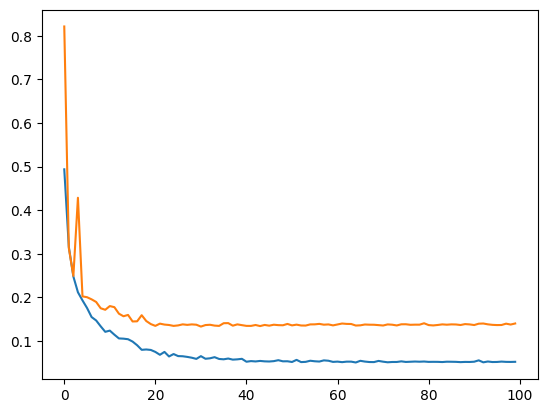

In [7]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, cls_label, seg_label) in enumerate(train_loader):
        image, cls_label, seg_label = image.to(device), cls_label.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output_cls, output_seg = model(image)

        # Calculate loss
        loss1 = loss_function(output_seg, seg_label)
        loss2 = loss_function(output_cls, cls_label)
        
        loss = loss1 + 0.1 * loss2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, cls_label, seg_label in test_loader:
            image, cls_label, seg_label = image.to(device), cls_label.to(device), seg_label.to(device)
            y_predict_cls, y_predict_seg = model(image)
            loss1 = loss_function(y_predict_seg, seg_label)
            loss2 = loss_function(y_predict_cls, cls_label)
            loss = loss1 + 0.1 * loss2
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/ResNet50_Multi.pt")

./Dataset_BUSI_with_GT/malignant/malignant (30).png


/tmp/ipykernel_3307028/1800348196.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)


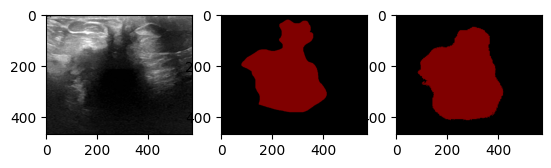

0.7591788574112471
0.8958755380325222
./Dataset_BUSI_with_GT/benign/benign (110).png


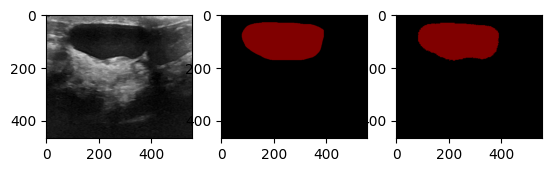

0.9261452982492924
0.9874421796597178
./Dataset_BUSI_with_GT/benign/benign (245).png


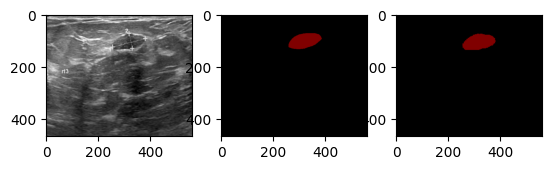

0.8048704339681548
0.995102725235461
./Dataset_BUSI_with_GT/benign/benign (22).png


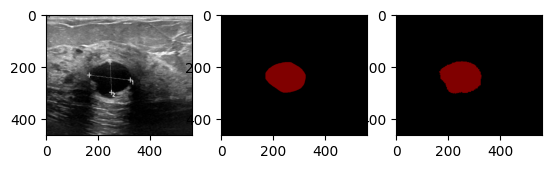

0.8810235095466944
0.9925721699643205
./Dataset_BUSI_with_GT/benign/benign (399).png


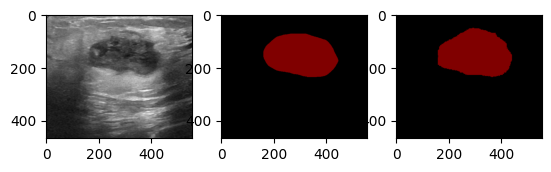

0.8927001768123264
0.9810693499942067
./Dataset_BUSI_with_GT/malignant/malignant (133).png


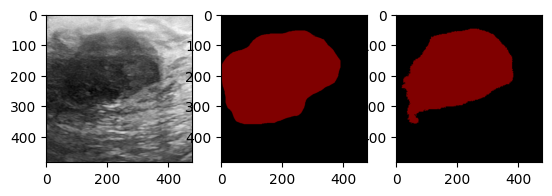

0.7907165298469646
0.8853464283731346
./Dataset_BUSI_with_GT/benign/benign (219).png


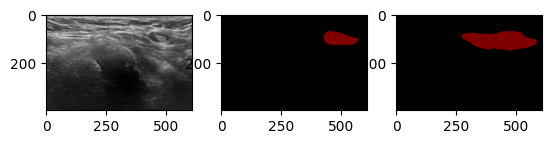

0.34294817090516017
0.9508008860867343
./Dataset_BUSI_with_GT/benign/benign (427).png


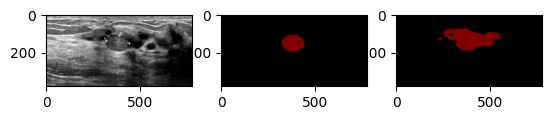

0.36262553802008607
0.9506923055578679
./Dataset_BUSI_with_GT/benign/benign (381).png


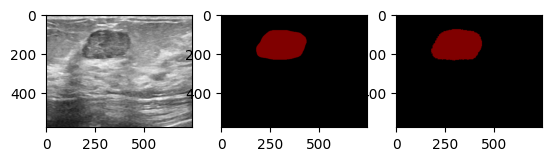

0.9295437767606674
0.9940169461349623
./Dataset_BUSI_with_GT/benign/benign (55).png


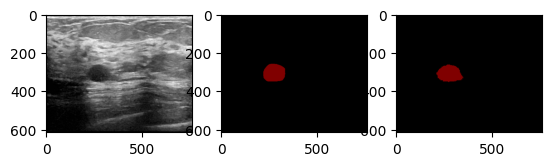

0.8495756212291645
0.9968033830681438
./Dataset_BUSI_with_GT/malignant/malignant (1).png


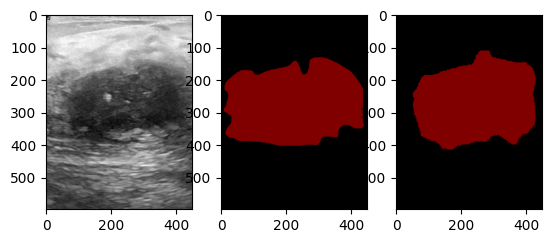

0.797797122772601
0.896071841193152
./Dataset_BUSI_with_GT/benign/benign (362).png


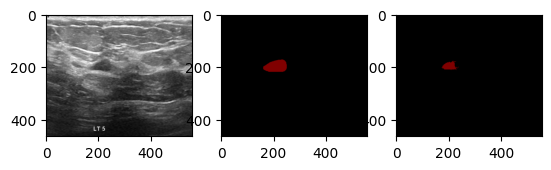

0.38561893203883496
0.9921260454861827
./Dataset_BUSI_with_GT/benign/benign (15).png


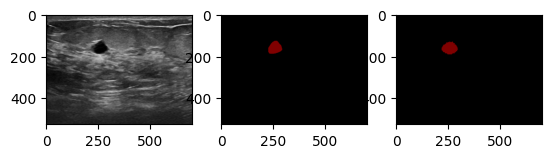

0.8038834951456311
0.9980673977934986
./Dataset_BUSI_with_GT/benign/benign (14).png


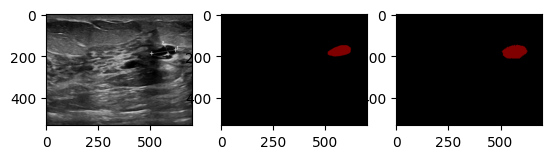

0.7122408687068115
0.9952322538436376
./Dataset_BUSI_with_GT/malignant/malignant (62).png


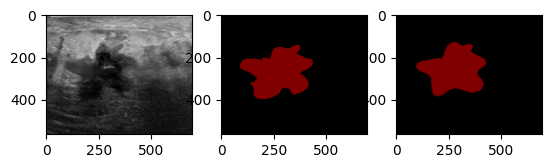

0.8339187155042649
0.9720428604298276
./Dataset_BUSI_with_GT/benign/benign (435).png


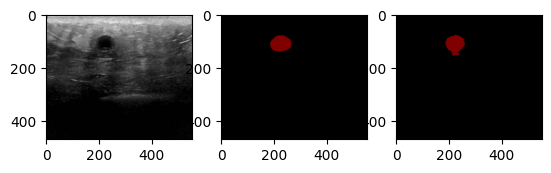

0.7870477068448951
0.9963831794357917
./Dataset_BUSI_with_GT/benign/benign (191).png


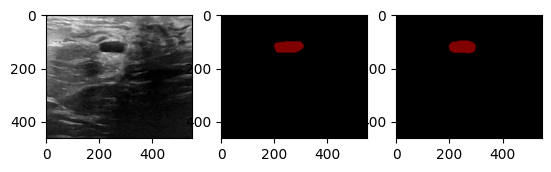

0.8318365514144589
0.997009765172747
./Dataset_BUSI_with_GT/malignant/malignant (145).png


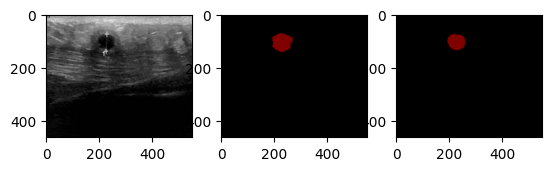

0.7766497461928934
0.9963170670461203
./Dataset_BUSI_with_GT/benign/benign (335).png


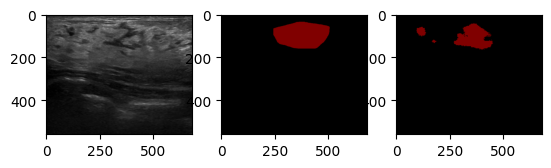

0.480345540996697
0.9610363455755283
./Dataset_BUSI_with_GT/benign/benign (259).png


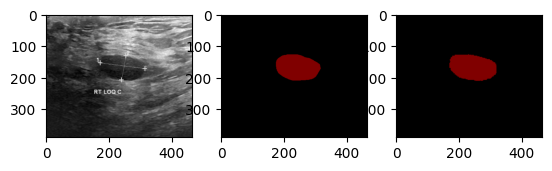

0.9026147015293537
0.9942683592525058
./Dataset_BUSI_with_GT/benign/benign (45).png


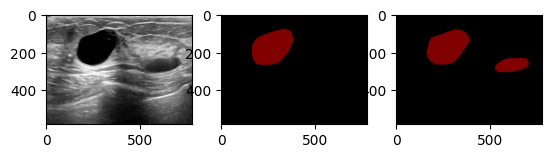

0.7077032303869365
0.9705645430366352
./Dataset_BUSI_with_GT/benign/benign (344).png


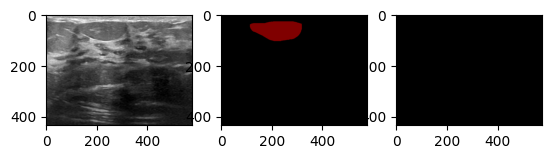

0.0
0.9511048707117256
./Dataset_BUSI_with_GT/benign/benign (199).png


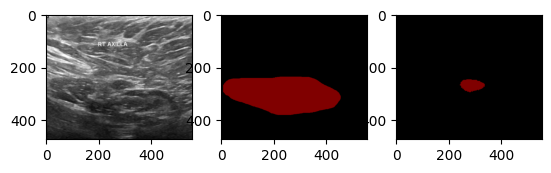

0.06746568326162672
0.8247290090298235
./Dataset_BUSI_with_GT/benign/benign (240).png


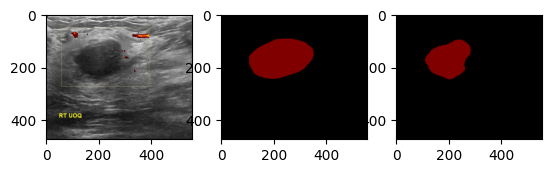

0.630031179138322
0.9574153976656362
./Dataset_BUSI_with_GT/malignant/malignant (140).png


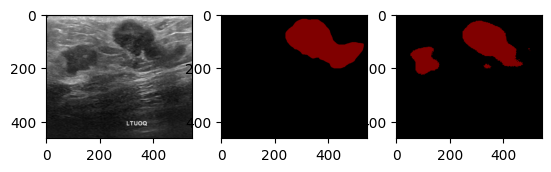

0.5661079070770226
0.9305411748464141
./Dataset_BUSI_with_GT/benign/benign (385).png


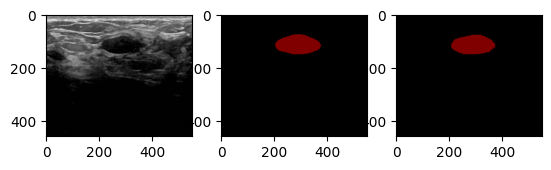

0.9267752967209817
0.9970058895140328
./Dataset_BUSI_with_GT/benign/benign (125).png


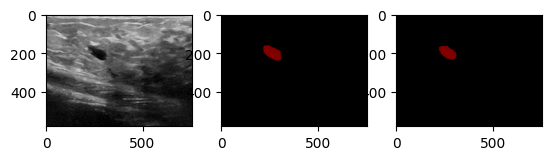

0.843818217900377
0.9981812551419407
./Dataset_BUSI_with_GT/benign/benign (72).png


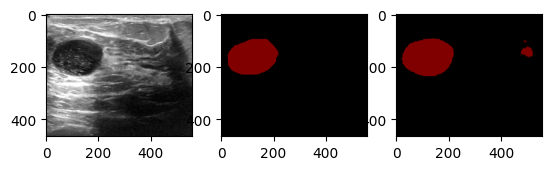

0.8501462599247807
0.9849745035845823
./Dataset_BUSI_with_GT/malignant/malignant (56).png


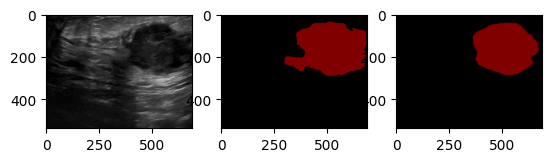

0.8030275447760149
0.9551859816806053
./Dataset_BUSI_with_GT/benign/benign (196).png


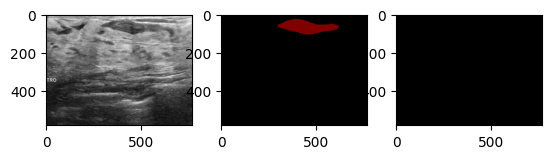

0.0
0.965641037183758
./Dataset_BUSI_with_GT/malignant/malignant (120).png


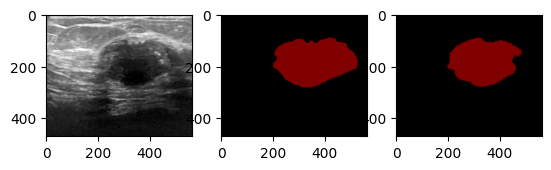

0.8105746026914799
0.9617508648088641
./Dataset_BUSI_with_GT/benign/benign (346).png


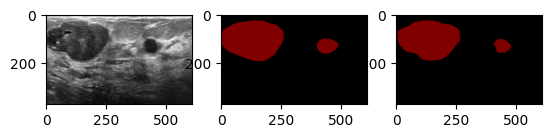

0.8999922694359265
0.9798498473551951
./Dataset_BUSI_with_GT/benign/benign (139).png


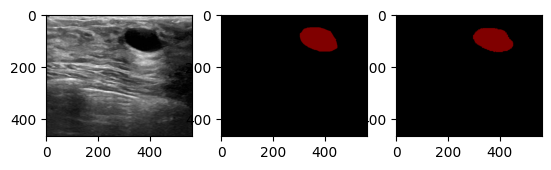

0.9111675126903553
0.9961330850089964
./Dataset_BUSI_with_GT/malignant/malignant (59).png


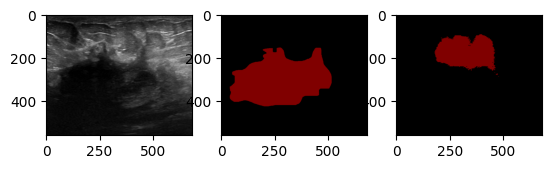

0.1346221504542133
0.7390985071217012
./Dataset_BUSI_with_GT/malignant/malignant (8).png


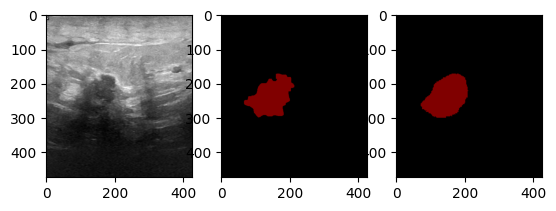

0.847336804164998
0.9900167086565507
./Dataset_BUSI_with_GT/benign/benign (319).png


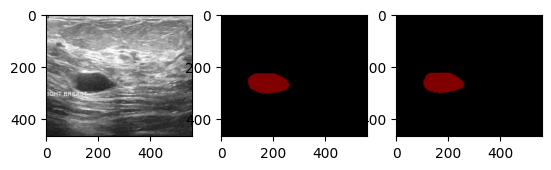

0.9225945522241819
0.9968663726081299
./Dataset_BUSI_with_GT/benign/benign (303).png


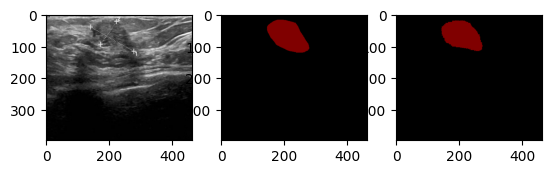

0.8598036238485677
0.9921208328592559
./Dataset_BUSI_with_GT/benign/benign (434).png


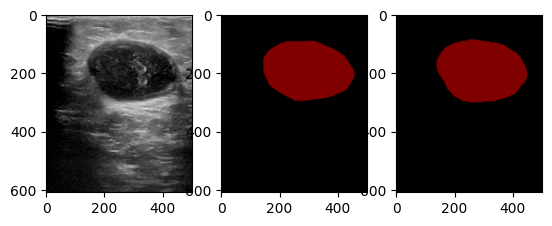

0.9304966686856451
0.9856533918866649
./Dataset_BUSI_with_GT/benign/benign (28).png


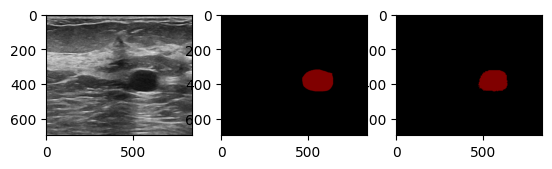

0.8830406263224715
0.996111795977441
./Dataset_BUSI_with_GT/benign/benign (294).png


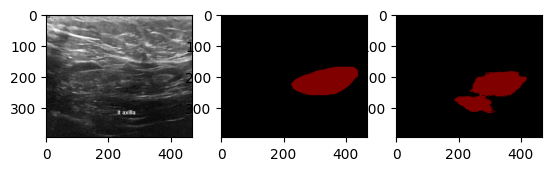

0.5347571189279732
0.9490863264020164
./Dataset_BUSI_with_GT/benign/benign (122).png


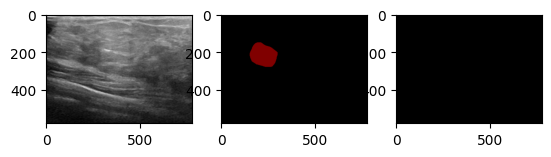

0.0
0.9682510893465712
./Dataset_BUSI_with_GT/benign/benign (129).png


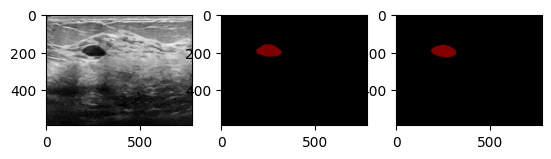

0.8818908883176235
0.9981571030640668
./Dataset_BUSI_with_GT/malignant/malignant (181).png


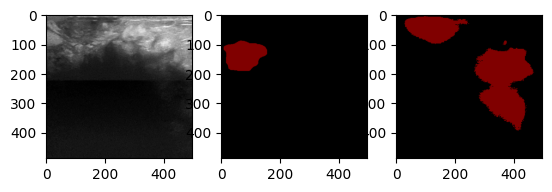

0.0
0.7609756902068147
./Dataset_BUSI_with_GT/benign/benign (171).png


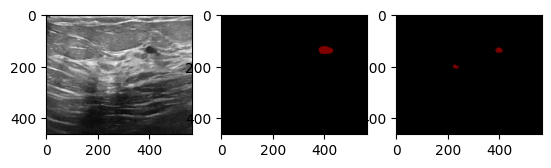

0.26851851851851855
0.9954705817149104
./Dataset_BUSI_with_GT/malignant/malignant (89).png


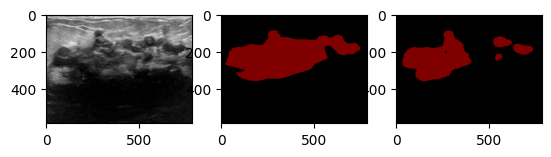

0.6016739053441944
0.8918720620158177
./Dataset_BUSI_with_GT/benign/benign (395).png


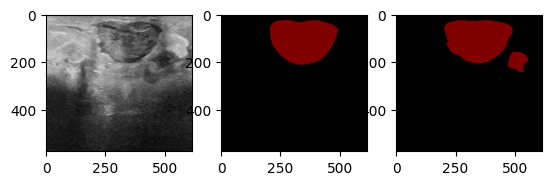

0.8330155271043312
0.9746602392475341
./Dataset_BUSI_with_GT/malignant/malignant (44).png


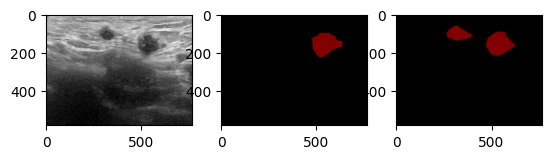

0.5753171747775042
0.9792119977661761
./Dataset_BUSI_with_GT/benign/benign (264).png


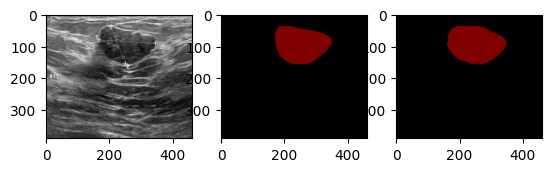

0.903137789904502
0.9896573072580939
./Dataset_BUSI_with_GT/benign/benign (33).png


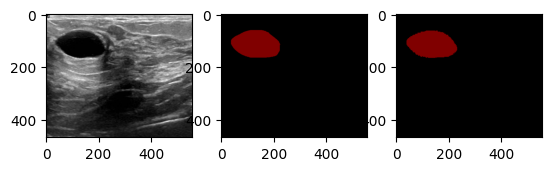

0.9415874614464657
0.9962160905854865
./Dataset_BUSI_with_GT/benign/benign (44).png


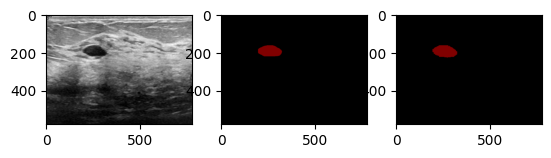

0.8894886789623632
0.9983428072889496
./Dataset_BUSI_with_GT/malignant/malignant (138).png


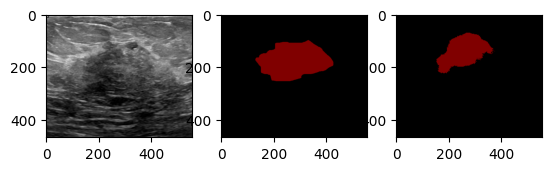

0.4363121714516781
0.92019497354281
./Dataset_BUSI_with_GT/benign/benign (180).png


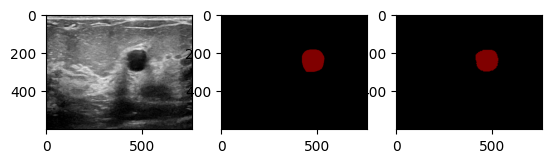

0.8853725392474459
0.9969137252007756
./Dataset_BUSI_with_GT/malignant/malignant (54).png


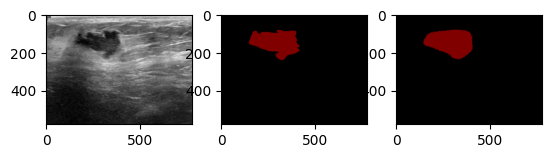

0.8689721231338354
0.9906516068066294
./Dataset_BUSI_with_GT/malignant/malignant (203).png


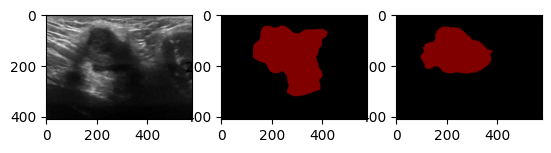

0.5745732412632759
0.8812211603861756
./Dataset_BUSI_with_GT/benign/benign (239).png


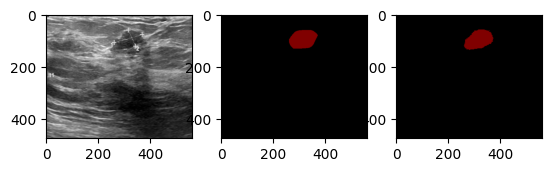

0.83760177646188
0.9957681061021055
./Dataset_BUSI_with_GT/benign/benign (23).png


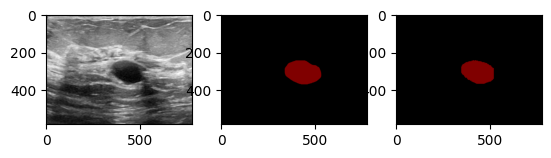

0.8786181627846114
0.9946978651991102
./Dataset_BUSI_with_GT/benign/benign (398).png


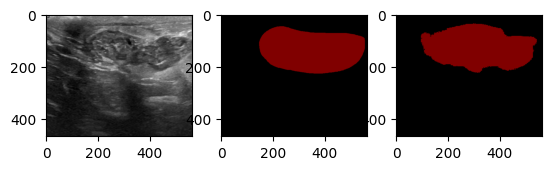

0.763535575973878
0.9271653911644182
./Dataset_BUSI_with_GT/benign/benign (277).png


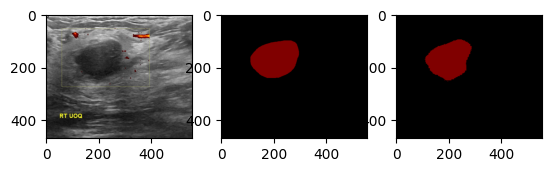

0.8735312455038128
0.9891280148423005
./Dataset_BUSI_with_GT/benign/benign (235).png


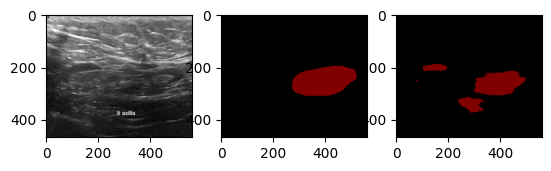

0.48806596267901053
0.9430534547678049
./Dataset_BUSI_with_GT/benign/benign (334).png


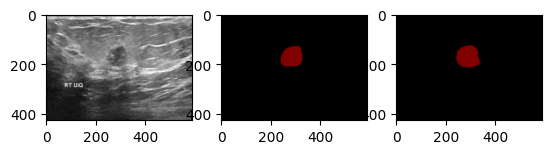

0.8245113425595663
0.9949823566606156
./Dataset_BUSI_with_GT/benign/benign (217).png


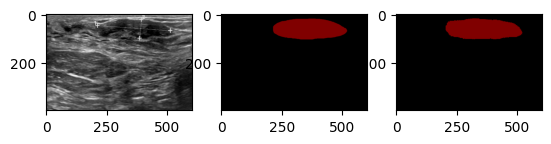

0.9054096240467377
0.9902922841738143
./Dataset_BUSI_with_GT/malignant/malignant (52).png


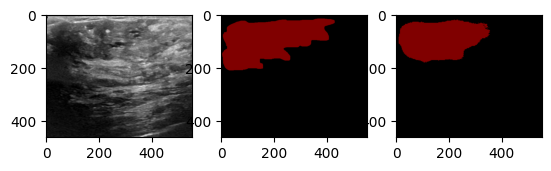

0.7300221975582686
0.9322923190402628
./Dataset_BUSI_with_GT/benign/benign (365).png


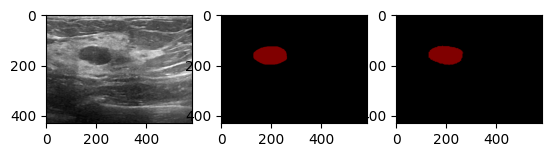

0.9006345025739255
0.9965888401645576
./Dataset_BUSI_with_GT/benign/benign (409).png


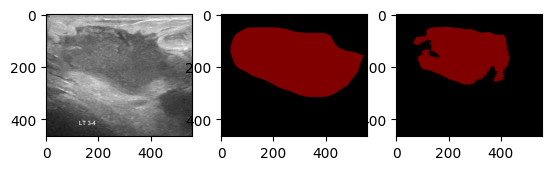

0.5904172622836215
0.80705160659251
./Dataset_BUSI_with_GT/benign/benign (273).png


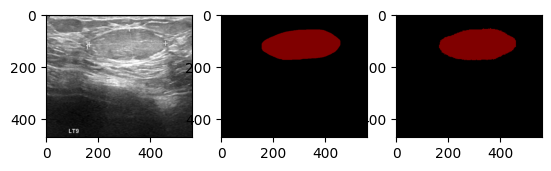

0.9369359879209241
0.992388443657107
./Dataset_BUSI_with_GT/benign/benign (153).png


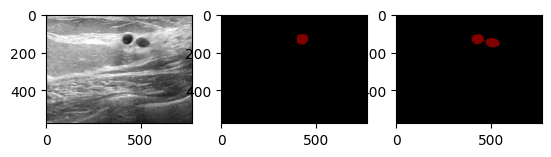

0.44133219470538004
0.9925750889808963
./Dataset_BUSI_with_GT/benign/benign (400).png


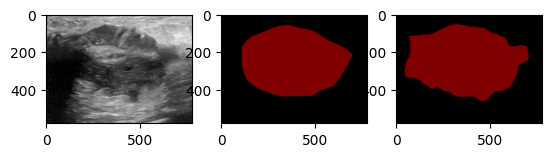

0.8718057200880014
0.9155318288892296
./Dataset_BUSI_with_GT/malignant/malignant (33).png


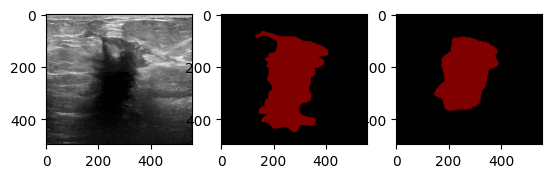

0.6938969516445909
0.9168946471893873
./Dataset_BUSI_with_GT/benign/benign (369).png


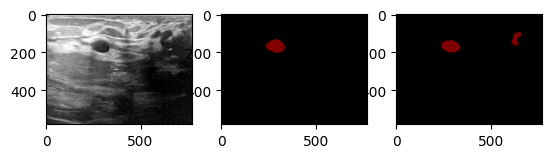

0.6422635536208944
0.9938872522612884
./Dataset_BUSI_with_GT/malignant/malignant (24).png


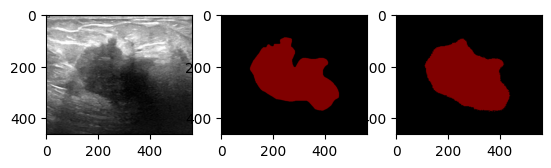

0.8627670083726052
0.9591206649525068
./Dataset_BUSI_with_GT/benign/benign (160).png


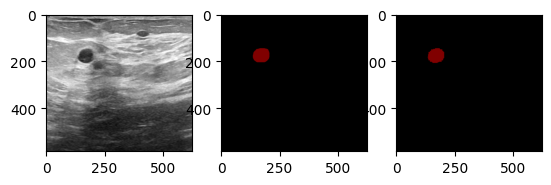

0.9199464524765729
0.9991731286158338
./Dataset_BUSI_with_GT/benign/benign (35).png


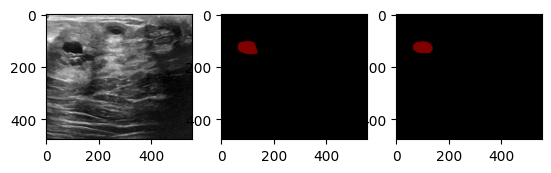

0.8484848484848485
0.9981677151407805
./Dataset_BUSI_with_GT/benign/benign (187).png


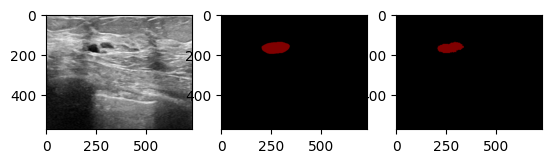

0.7734244495064541
0.9963954996895588
./Dataset_BUSI_with_GT/malignant/malignant (172).png


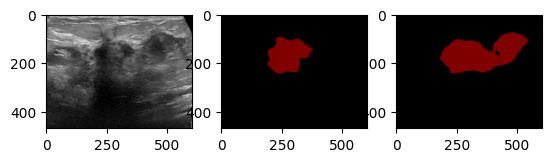

0.45808003383200296
0.9226322323561265
./Dataset_BUSI_with_GT/benign/benign (284).png


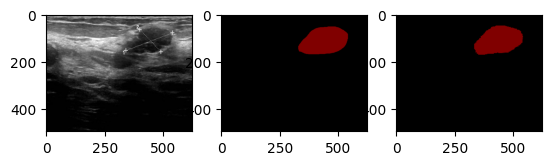

0.92426685478182
0.9948313393468161
./Dataset_BUSI_with_GT/benign/benign (37).png


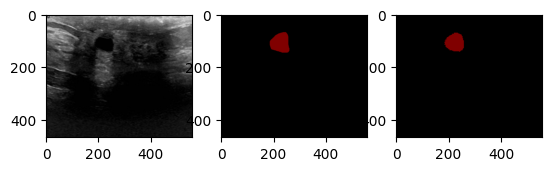

0.8578844905905256
0.9974406918312493
./Dataset_BUSI_with_GT/benign/benign (241).png


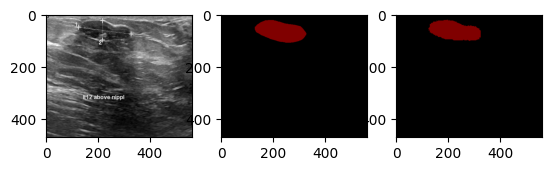

0.8823763005321261
0.9941599104072684
./Dataset_BUSI_with_GT/benign/benign (324).png


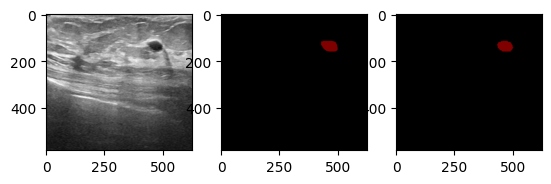

0.8820976491862568
0.9991007367889683
./Dataset_BUSI_with_GT/benign/benign (7).png


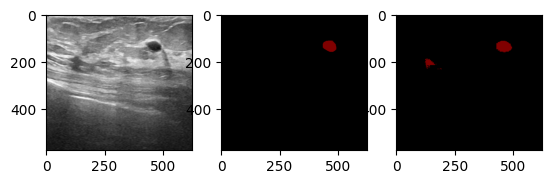

0.5928954045672399
0.9959728810912265
./Dataset_BUSI_with_GT/malignant/malignant (36).png


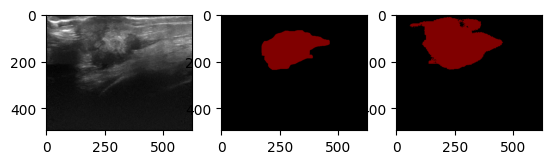

0.5575364667747164
0.9166852169667028
./Dataset_BUSI_with_GT/benign/benign (169).png


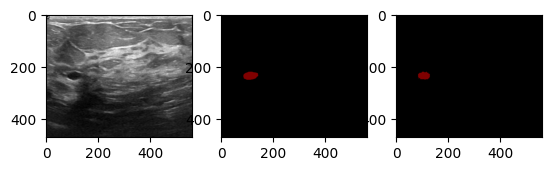

0.7175414364640884
0.9984393482657306
./Dataset_BUSI_with_GT/malignant/malignant (64).png


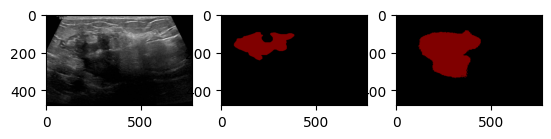

0.3803050455150018
0.8968401620606664
./Dataset_BUSI_with_GT/benign/benign (215).png


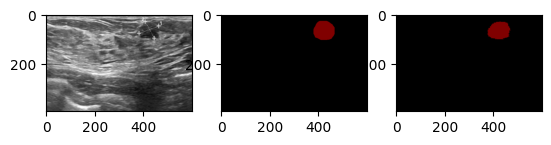

0.8716678058783321
0.9967698785801229
./Dataset_BUSI_with_GT/malignant/malignant (7).png


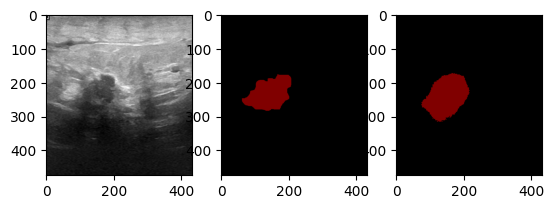

0.672627235213205
0.9768668436695878
./Dataset_BUSI_with_GT/benign/benign (157).png


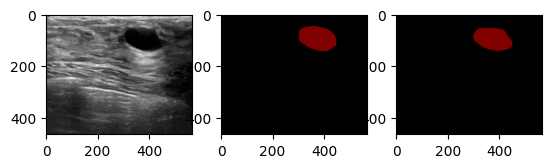

0.8916225749559082
0.9951527151105922
./Dataset_BUSI_with_GT/benign/benign (336).png


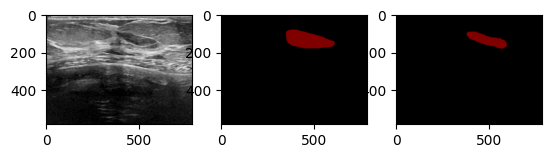

0.5292357900462333
0.9806948084536887
./Dataset_BUSI_with_GT/benign/benign (428).png


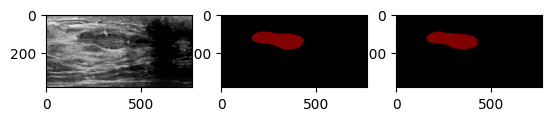

0.9214190981432361
0.9948679822725238
./Dataset_BUSI_with_GT/benign/benign (417).png


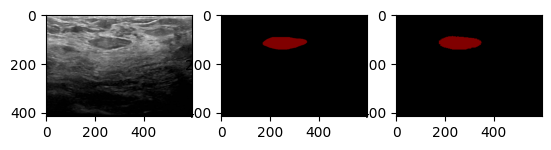

0.8987891550408003
0.9968269687029357
./Dataset_BUSI_with_GT/benign/benign (436).png


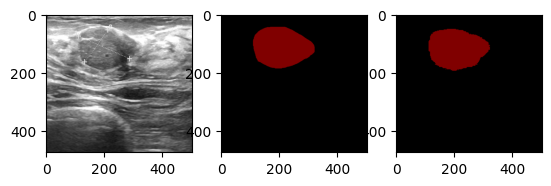

0.8903217780726489
0.9877816119033431
./Dataset_BUSI_with_GT/malignant/malignant (93).png


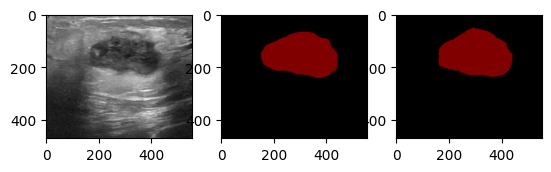

0.9164114117915095
0.9852706988611779
./Dataset_BUSI_with_GT/benign/benign (141).png


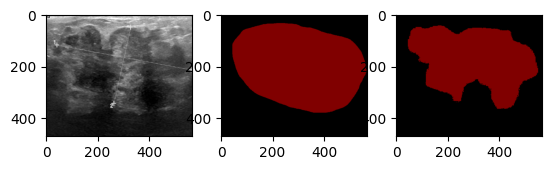

0.7432677630252585
0.7823584347093616
./Dataset_BUSI_with_GT/benign/benign (420).png


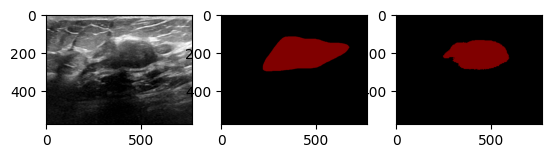

0.6718744483282139
0.9538524181114424
./Dataset_BUSI_with_GT/benign/benign (243).png


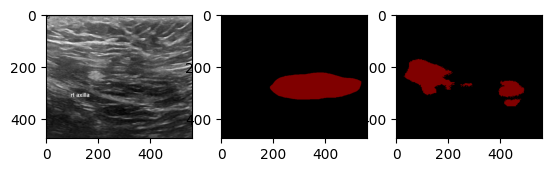

0.12734323015854807
0.8536083109124991
./Dataset_BUSI_with_GT/benign/benign (265).png


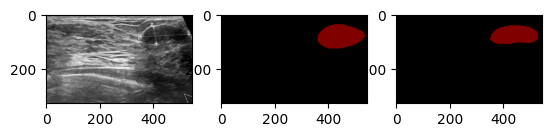

0.7786149406861174
0.9836294882585143
./Dataset_BUSI_with_GT/malignant/malignant (55).png


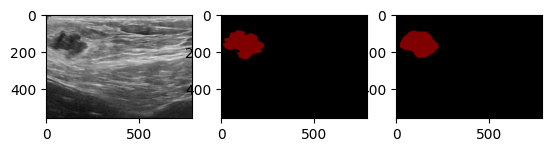

0.8583900429799427
0.9924301711408352
./Dataset_BUSI_with_GT/benign/benign (64).png


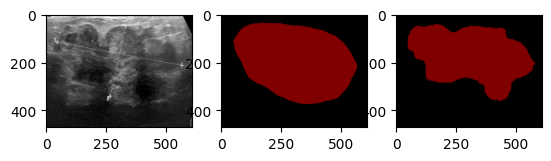

0.7866461720187481
0.846379893141424
./Dataset_BUSI_with_GT/malignant/malignant (45).png


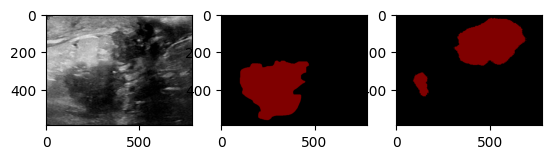

0.05202190823725348
0.6920324280573957
./Dataset_BUSI_with_GT/malignant/malignant (128).png


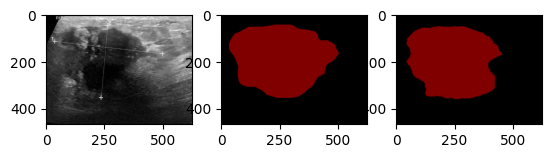

0.8286366280370486
0.9042090203297583
./Dataset_BUSI_with_GT/benign/benign (387).png


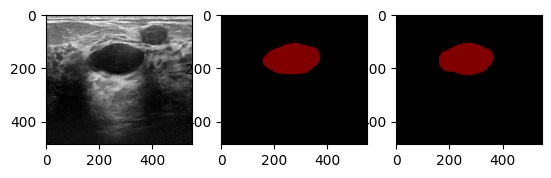

0.9274425650088362
0.9942160469478277
./Dataset_BUSI_with_GT/benign/benign (99).png


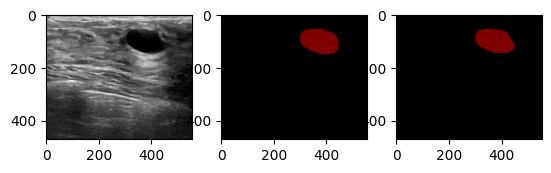

0.9139860756146999
0.9961047720533359
./Dataset_BUSI_with_GT/malignant/malignant (28).png


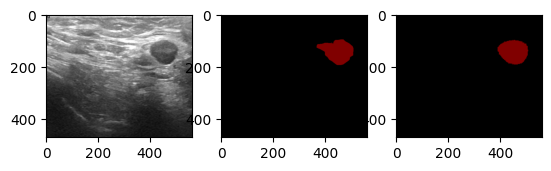

0.8643792618248728
0.9951084113462995
./Dataset_BUSI_with_GT/benign/benign (24).png


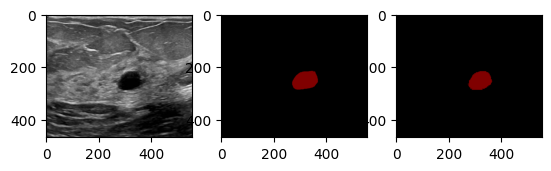

0.8513948497854077
0.9967397828875872
./Dataset_BUSI_with_GT/benign/benign (30).png


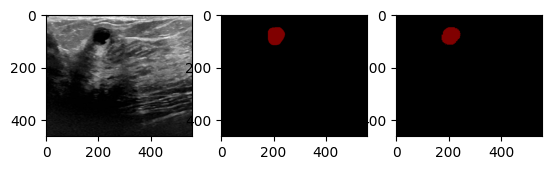

0.9006982156710628
0.9984873016060603
./Dataset_BUSI_with_GT/benign/benign (411).png


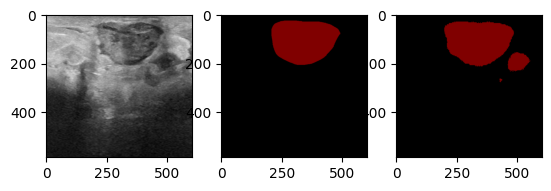

0.8356920584850164
0.9754619387901262
./Dataset_BUSI_with_GT/benign/benign (402).png


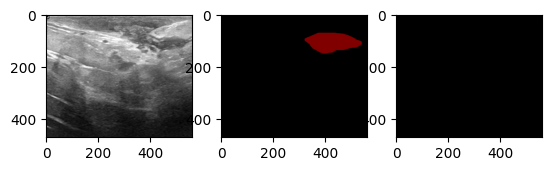

0.0
0.9541900885184468
./Dataset_BUSI_with_GT/benign/benign (364).png


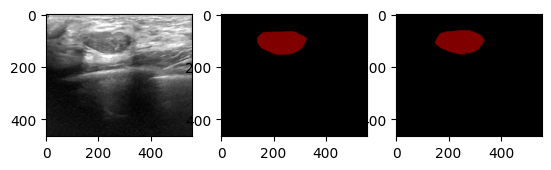

0.8127271480490983
0.9889501644730188
./Dataset_BUSI_with_GT/malignant/malignant (210).png


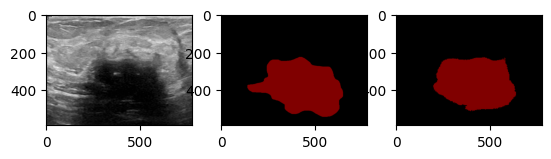

0.8049469769497017
0.9423400329812073
./Dataset_BUSI_with_GT/benign/benign (144).png


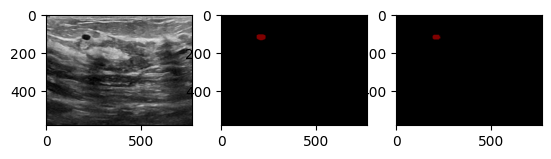

0.7173566878980892
0.9992034983251028
./Dataset_BUSI_with_GT/malignant/malignant (157).png


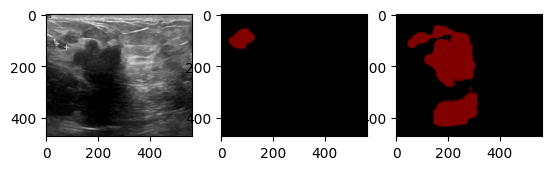

0.06254348666408968
0.8151580744489497
./Dataset_BUSI_with_GT/benign/benign (213).png


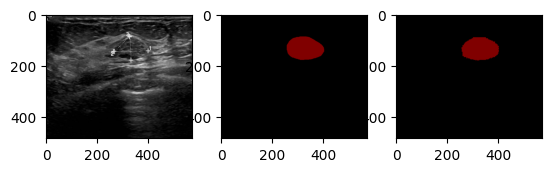

0.9127870042653599
0.9964197898815289
./Dataset_BUSI_with_GT/benign/benign (290).png


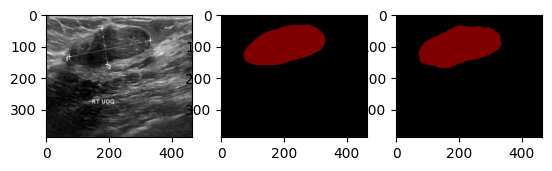

0.916433332018772
0.9865585770740959
./Dataset_BUSI_with_GT/malignant/malignant (188).png


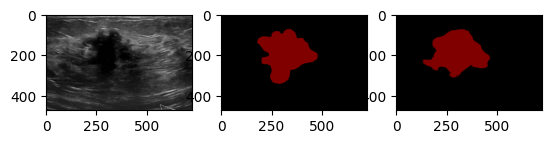

0.7328321087505458
0.9536881320901883
./Dataset_BUSI_with_GT/benign/benign (253).png


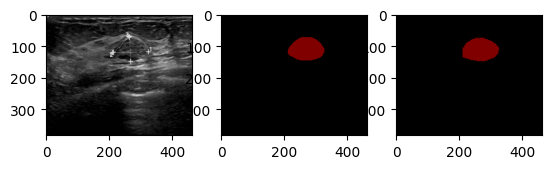

0.8957474043521547
0.9957142272453532
./Dataset_BUSI_with_GT/malignant/malignant (152).png


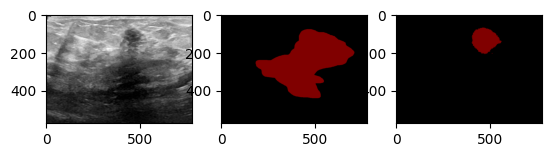

0.13998333898984913
0.8063467287923245
./Dataset_BUSI_with_GT/malignant/malignant (190).png


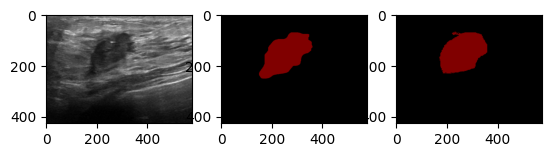

0.8287579033244952
0.9813947304274603
./Dataset_BUSI_with_GT/benign/benign (285).png


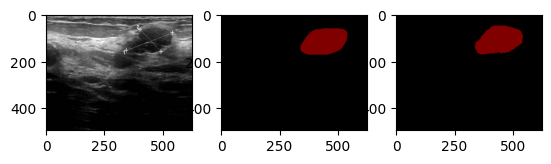

0.8756523942234609
0.9915805797529068
./Dataset_BUSI_with_GT/benign/benign (108).png


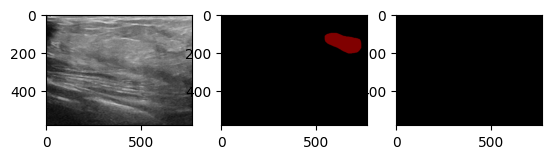

0.0
0.9690386497392517
./Dataset_BUSI_with_GT/benign/benign (173).png


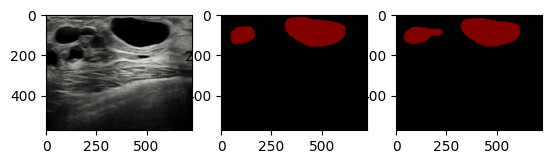

0.8765015431756111
0.9852279940402047
./Dataset_BUSI_with_GT/benign/benign (432).png


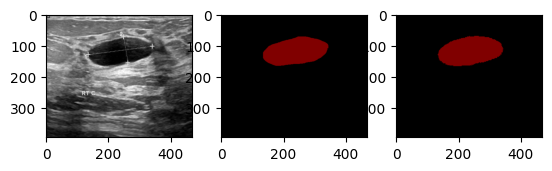

0.9268388106416275
0.9934221325891706
./Dataset_BUSI_with_GT/malignant/malignant (150).png


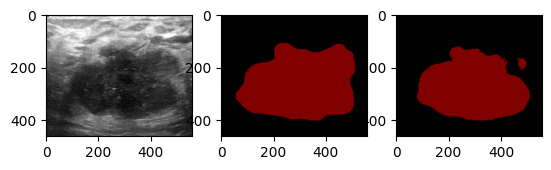

0.8293189650987816
0.898061658172288
./Dataset_BUSI_with_GT/benign/benign (238).png


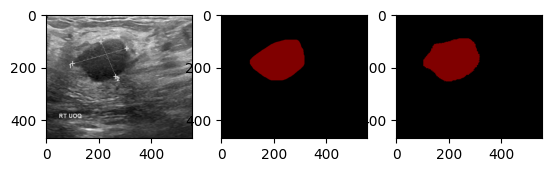

0.8844703595724004
0.9875131821638495
./Dataset_BUSI_with_GT/malignant/malignant (202).png


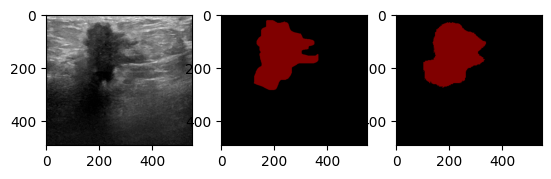

0.8253195978652104
0.9702831901757587
./Dataset_BUSI_with_GT/malignant/malignant (46).png


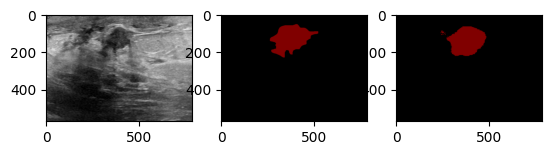

0.7322605798539732
0.9823329240484125
./Dataset_BUSI_with_GT/benign/benign (67).png


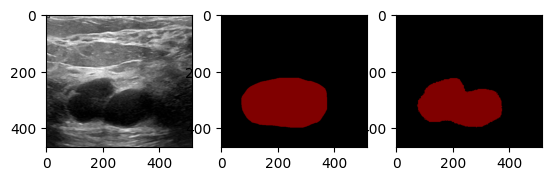

0.8192849598885419
0.9606773163564174
./Dataset_BUSI_with_GT/benign/benign (156).png


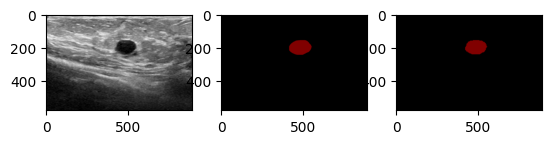

0.8955435996345549
0.9979685109323331
./Dataset_BUSI_with_GT/malignant/malignant (148).png


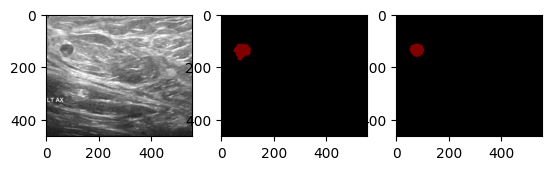

0.7362218370883882
0.9970192398082286
./Dataset_BUSI_with_GT/benign/benign (220).png


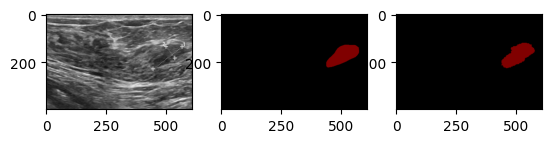

0.8422271096191689
0.9941724244082638
./Dataset_BUSI_with_GT/malignant/malignant (165).png


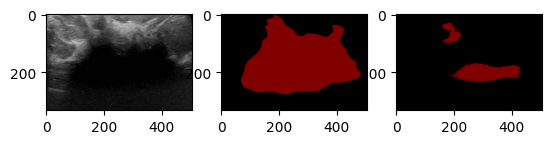

0.18371038166428805
0.6264814850736136
./Dataset_BUSI_with_GT/benign/benign (76).png


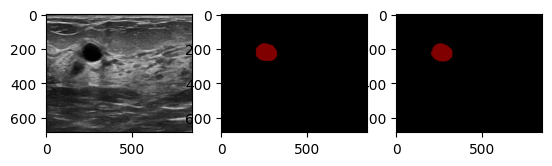

0.9136879632235669
0.9983891893595452
./Dataset_BUSI_with_GT/malignant/malignant (131).png


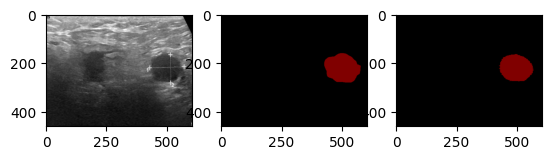

0.8532979257876983
0.9923317889366172
average tumor IoU: 0.7109825037776268
average background IoU: 0.9583590470746666


In [7]:
# Step 4: IoU and segmentation results
model = torch.load("./save_models/ResNet50_Multi.pt")
model = model.to(device)
from utility import VOCPalette

total_tumor_IoU = []
total_background_IoU = []
palette = VOCPalette(nb_class=2)

for test_image in images_test:
    image = Image.open(test_image)
    print(test_image)
    label = Image.open(test_image[:-4] + "_mask.png")
    
    image_resize = image.convert("RGB").resize((224, 224))
    image_resize = np.array(image_resize)
    img_new = np.float32(image_resize)
    img_new = img_new /127.5 -1

  
    tfms = transforms.Compose([
            transforms.ToTensor()
        ])

    image_tensor = tfms(img_new).unsqueeze(0).to(device)

    predict = model(image_tensor)[1].squeeze(0)

    predict_label = torch.argmax(predict, 0)

    predict_label = predict_label.cpu().numpy().astype('uint8')

    # resize the predict result to original size
    
    PIL_predicr_pal_U = palette.genlabelpal(predict_label)
    PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(PIL_img_pal)
    plt.show()

    # Compute IoU between thresh1 and label

    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    # IoU

    print(compute_iou(np.array(PIL_img_pal), np.array(label)))
    print(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
    total_tumor_IoU.append(compute_iou(np.array(PIL_img_pal), np.array(label)))
    total_background_IoU.append(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
print("average tumor IoU:", np.mean(total_tumor_IoU))
print("average background IoU:", np.mean(total_background_IoU))

In [8]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix
model = torch.load("./save_models/ResNet50_Multi.pt")
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)
    
    true_labels = []
    probabilities = []
    predictions = []  # Correctly initialize the predictions list

    with torch.no_grad():  # Do not compute gradients
        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
            preds = (probs >= threshold).cpu().numpy().astype(int)  # Binary predictions based on the threshold
            
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            predictions.extend(preds)  # Add the predictions to the list

    # Convert lists to numpy arrays for consistency
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)
    predictions = np.array(predictions)
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, probabilities)  # AUC using probabilities

    # Compute confusion matrix and extract TN, FP, FN, TP for calculating TPR and FPR
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    
    return accuracy, precision, f1, auc, tpr, fpr

# Assuming 'device' and 'test_loader' are already defined
# Evaluate the model and print the metrics
accuracy, precision, f1, auc, tpr, fpr = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nF1 Score: {f1}\nAUC: {auc}\nTPR: {tpr}\nFPR: {fpr}")


Accuracy: 0.9230769230769231
Precision: 0.8222222222222222
F1 Score: 0.8809523809523809
AUC: 0.9537897999436461
TPR: 0.9487179487179487
FPR: 0.08791208791208792
